In [81]:
#%%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd
import scanpy as sc

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

import geojson
import json
from shapely.geometry import shape
import geopandas as gpd

import scanpy as sc
import pandas as pd
import h5py
import openslide

import seaborn as sns
from shapely.geometry import Point, Polygon
from sklearn.decomposition import PCA
from scipy.sparse import issparse
from collections import defaultdict


In [12]:
#%%
# Filepaths
cellvit_file = "/rsrch5/home/plm/phacosta/CellViT/example/output/preprocessing/original/Xenium_Prime_Human_Lung_Cancer_FFPE_he_image.ome/cell_detection/cells.geojson"
feature_matrix_file = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_002um/filtered_feature_bc_matrix.h5"
tissue_positions_file = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_002um/spatial/tissue_positions.parquet"


#%%

def bins_to_pixels(n_bins=2, bin_size_um=2.0, mpp=0.2738):
    """
    Convert a desired number of bins to a pixel distance, 
    given each bin is bin_size_um µm wide and the image has mpp µm/pixel.
    """
    distance_um = n_bins * bin_size_um  # total microns
    distance_pixels = distance_um / mpp
    return distance_pixels

def expand_cell_polygons(nuclei_gdf, n_bins=2, bin_size_um=2.0, mpp=0.2738):
    """
    Expand each nucleus polygon by `n_bins` * `bin_size_um` microns, 
    accounting for mpp (µm/pixel).
    """
    distance_pixels = (n_bins * bin_size_um) / mpp
    # or use the helper function from above

    nuclei_gdf["expanded_geom"] = nuclei_gdf.geometry.buffer(distance_pixels)
    return nuclei_gdf

def expand_cell(
    adata_bins,
    bin_gdf,
    nucleus_gdf,
    n_bins=2,
    bin_size_um=2.0,
    mpp=0.2738,
    tie_break_method="pca",
    grouped_adata=None,
    n_pcs=10,
    subset_pca=True
):
    """
    Expand each nucleus polygon, then assign bins to the expanded cell.
    If tie-break_method="pca", do a selective PCA approach on only 
    the ambiguous bins + relevant cells, akin to expand_labels().

    Parameters
    ----------
    adata_bins : AnnData
        bin-level AnnData, rows=bins, columns=genes.
        Must have .obs_names that match bin_gdf or have bin_gdf["barcode"].
    bin_gdf : GeoDataFrame
        geometry=Point for each bin in pixel coords. Possibly "barcode" col.
    nucleus_gdf : GeoDataFrame
        Each row is "id" + geometry=Polygon for the nucleus. Also pixel coords.
    n_bins : int
        # of bin widths for expansion
    bin_size_um : float
        microns per bin
    mpp : float
        microns per pixel (scaling factor)
    tie_break_method : str
        "pca" => selective PCA-based tie break,
        "geometry" => nearest centroid,
        or any other approach you define.
    grouped_adata : AnnData, optional
        If you already have per-cell expression. We can do partial PCA on the relevant cells here.
    n_pcs : int, default=10
        Number of PCs for tie-break
    subset_pca : bool, default=True
        If True, only run PCA on ambiguous bins + relevant cells, 
        else we do a larger approach. Typically keep True to minimize overhead.

    Returns
    -------
    pd.DataFrame with columns ["barcode", "cell_id"] for each bin assignment.
    """

    #
    # 1) Expand polygons
    print("Expanding polygons")
    distance_pixels = (n_bins * bin_size_um) / mpp
    nuc_gdf_expanded = nucleus_gdf.copy()
    nuc_gdf_expanded["expanded_geom"] = nuc_gdf_expanded.geometry.buffer(distance_pixels)

    expanded_nuc_gdf = nuc_gdf_expanded.drop(columns="geometry").rename(columns={"expanded_geom": "geometry"})

    #
    # 2) Spatial Join
    print("Assigning bins to polygons")
    bin_polygon_join = gpd.sjoin(bin_gdf, expanded_nuc_gdf, how="inner", predicate="within")
    duplicates = bin_polygon_join.groupby(bin_polygon_join.index).size()
    multi_bins = duplicates[duplicates > 1].index

    bin_to_cell = {}

    # Single-hit bins
    single_bin_polygon_join = bin_polygon_join.loc[~bin_polygon_join.index.isin(multi_bins)]
    for bin_idx, row in single_bin_polygon_join.iterrows():
        bin_to_cell[bin_idx] = row["id"]
    print(single_bin_polygon_joinr of single hit bins:", single_bin_polygon_join.shape)
    
    
    print("Finding multi-hit bins")
    # Multi-hit bins => tie-break
    multi_bin_polygon_join = bin_polygon_join.loc[bin_polygon_join.index.isin(multi_bins)]
    
    print("Number of multi-hit bins:", multi_bin_polygon_join.shape)
    
    print("Performing tie breaker")
    if tie_break_method == "geometry":
        # same geometry approach as before
        expanded_nuc_gdf["centroid_x"] = expanded_nuc_gdf.geometry.centroid.x
        expanded_nuc_gdf["centroid_y"] = expanded_nuc_gdf.geometry.centroid.y

        for bin_idx, group_df in multi_bin_polygon_join.groupby(level=0):
            bin_pt = bin_gdf.loc[bin_idx, "geometry"]
            bin_x, bin_y = bin_pt.x, bin_pt.y
            best_cell, best_dist = None, float("inf")
            for _, row in group_df.iterrows():
                cell_id = row["id"]
                c_x = expanded_nuc_gdf.loc[row["index_right"], "centroid_x"]
                c_y = expanded_nuc_gdf.loc[row["index_right"], "centroid_y"]
                dist = np.hypot(bin_x - c_x, bin_y - c_y)
                if dist < best_dist:
                    best_dist = dist
                    best_cell = cell_id
            bin_to_cell[bin_idx] = best_cell

    elif tie_break_method == "pca":
        #
        # 2a) Identify the ambiguous bins + the relevant cells
        #
        # ambiguous bin indices
        ambiguous_bin_idxs = np.array(list(multi_bins))

        # from multi_bin_polygon_join, figure out which cells are relevant
        # i.e. any cell that appears for an ambiguous bin
        relevant_cells = multi_bin_polygon_join["id"].unique().tolist()

        # Step (1) Build a subset "smol" of bin indices that includes:
        #   - all ambiguous bins
        #   - the bins that define each relevant cell (original nucleus assignment)
        #     (or the bins from grouped_adata if we have it)

        # We'll store them in a set for efficiency
        smol_bins_set = set(ambiguous_bin_idxs)

        # If we do not have grouped_adata, we might rely on adata_bins.obs["id"] from a prior assignment
        # or do some naive approach. But let's assume we have "id" or grouped_adata:
        if grouped_adata is not None:
            # we only keep the relevant cell rows
            # so we can do a partial approach in grouped_adata. 
            # But grouped_adata is already cell-level data, so no bin-level array needed for them.
            pass
        else:
            # we'll do a naive approach: if adata_bins.obs["id"] exists, we find all bins that belong
            # to relevant_cells from the old nucleus assignment
            if "id" in adata_bins.obs:
                old_id_series = adata_bins.obs["id"]
                for rc in relevant_cells:
                    # gather the bin indices that have old_id=rc
                    these_bin_inds = np.where(old_id_series == rc)[0]
                    for x in these_bin_inds:
                        smol_bins_set.add(x)
            else:
                raise ValueError("No grouped_adata or adata_bins.obs['id'] found for partial cell sums")

        smol_bins = np.array(sorted(list(smol_bins_set)), dtype=int)
        print(smol_bins.shape)
        # Step (2) If needed, build partial "cell -> expression" from grouped_adata
        # If grouped_adata is not None, we only keep the relevant cell IDs
        if grouped_adata is not None:
            cell_mask = grouped_adata.obs["id"].isin(relevant_cells)
            # we keep only these rows
            grouped_adata_smol = grouped_adata[cell_mask, :].copy()
            # we'll do a partial PCA on them as well
        else:
            grouped_adata_smol = None

        #
        # 3) Extract the smaller matrix from adata_bins + transform
        #
        # we only log1p + PCA the smol bins. Let's create a submatrix
        print("Sparse Matrix Operations")
        X_full = adata_bins.X
        if issparse(X_full):
            X_full = X_full.tocsr()

        # submatrix for smol bins
        X_smol = X_full[smol_bins, :]
        # do log1p
        X_smol_log = X_smol
        if issparse(X_smol_log):
            X_smol_log = X_smol_log.toarray()
        X_smol_log = np.log1p(X_smol_log)

        # Fit PCA on these "smol" bins
        pca_model = PCA(n_components=n_pcs)
        pca_smol_bins = pca_model.fit_transform(X_smol_log)  # shape = (len(smol_bins), n_pcs)

        # We'll store them in a big array "pca_bins" of shape=(adata_bins.n_obs, n_pcs)
        # so we can do pca_bins[bin_idx], analogous to expand_labels approach
        pca_bins = np.zeros((adata_bins.n_obs, n_pcs), dtype=np.float32)
        pca_bins[smol_bins, :] = pca_smol_bins
        print("Finished PCA on ambiguous bins")
        
        # Step (3b) We also do the cell-level partial PCA
        cell_id_to_pca = {}
        if grouped_adata_smol is not None:
            # do log1p
            X_cells = grouped_adata_smol.X
            if issparse(X_cells):
                X_cells = X_cells.toarray()
            X_cells_log = np.log1p(X_cells)
            pca_cells = pca_model.transform(X_cells_log)
            for i, cid in enumerate(grouped_adata_smol.obs["id"]):
                cell_id_to_pca[cid] = pca_cells[i, :]

        else:
            # If no grouped_adata, do naive sum for relevant cells
            # from the smol bins. For each relevant cell, we sum bins 
            # that have old_id=rc. Then apply pca_model.transform
            # But we can do a 2-step approach or reuse partial_ logic. 
            # We'll do a toy approach:
            old_id_series = adata_bins.obs["id"]
            for rc in relevant_cells:
                these_bin_inds = np.where(old_id_series == rc)[0]
                # filter to intersection with smol bins if we want
                # or we can just sum them. 
                if len(these_bin_inds) == 0:
                    continue
                subX = X_full[these_bin_inds, :]
                if issparse(subX):
                    subX = subX.toarray()
                sum_expr = subX.sum(axis=0)
                sum_expr_log = np.log1p(sum_expr)
                sum_expr_pca = pca_model.transform(sum_expr_log.reshape(1, -1))[0]
                cell_id_to_pca[rc] = sum_expr_pca

        #
        # 4) For each ambiguous bin, find the best cell in PCA space
        #
        for bin_idx, group_df in multi_bin_polygon_join.groupby(level=0):
            # bin's pca
            bin_vec = pca_bins[bin_idx]
            best_cell, best_dist = None, float("inf")
            for _, row in group_df.iterrows():
                cid = row["id"]
                if cid not in cell_id_to_pca:
                    # skip or handle differently
                    continue
                cell_vec = cell_id_to_pca[cid]
                dist = np.linalg.norm(bin_vec - cell_vec)
                if dist < best_dist:
                    best_dist = dist
                    best_cell = cid

            bin_to_cell[bin_idx] = best_cell

    else:
        raise ValueError(f"Unknown tie_break_method: {tie_break_method}")

    #
    # 5) Build final DataFrame
    #
    results = []
    for b_idx, c_id in bin_to_cell.items():
        if "barcode" in bin_gdf.columns:
            bcode = bin_gdf.loc[b_idx, "barcode"]
        else:
            bcode = adata_bins.obs_names[b_idx]
        results.append((bcode, c_id))

    bin_to_cell_df = pd.DataFrame(results, columns=["barcode", "cell_id"])
    return bin_to_cell_df


In [26]:
# %%
# -----------------------------------------------------------------------------
# 2) LOAD & PARSE THE GEOJSON (NUCLEI POLYGONS) - WITHOUT CLASSIFICATION
# -----------------------------------------------------------------------------
with open(cellvit_file, "r") as f:
    data = json.load(f)

# The GeoJSON usually has {"type": "FeatureCollection", "features": [...]}:
features = data["features"] if "features" in data else data

all_polygons = []
all_ids = []

cell_counter = 0  # We'll make a new "Cell_0", "Cell_1", etc.

for feat_idx, feat in enumerate(features):
    geom = shape(feat["geometry"])  # could be MultiPolygon or Polygon

    # If it's a single Polygon:
    if geom.geom_type == "Polygon":
        # Make a brand new ID for this sub-polygon (which is presumably one cell)
        cell_id = f"Cell_{cell_counter}"
        cell_counter += 1

        all_polygons.append(geom)
        all_ids.append(cell_id)

    # If it's a MultiPolygon, we iterate each polygon inside it
    elif geom.geom_type == "MultiPolygon":
        for subpoly in geom.geoms:
            cell_id = f"Cell_{cell_counter}"
            cell_counter += 1

            all_polygons.append(subpoly)
            all_ids.append(cell_id)

    else:
        # If there are other geometry types, skip or handle them
        pass

# Now each sub-polygon is treated as a separate "cell".
# Build a GeoDataFrame with your newly created IDs:
nuclei_gdf = gpd.GeoDataFrame(
    {"id": all_ids},
    geometry=all_polygons
).reset_index(drop=True)

print("Number of per-cell polygons in nuclei_gdf:", len(nuclei_gdf))
print(nuclei_gdf.head())

# -----------------------------------------------------------------------------
# 3) LOAD VISIUM HD DATA (EXPRESSION + SPATIAL POSITIONS)
# -----------------------------------------------------------------------------
# 3A) Load gene expression into AnnData
adata = sc.read_10x_h5(feature_matrix_file)
print("Original adata shape:", adata.shape)

# 3B) Load tissue_positions and merge into adata.obs
df_positions = pd.read_parquet(tissue_positions_file)
df_positions = df_positions.set_index("barcode")
df_positions["index"] = df_positions.index  # optional clarity
df_positions = df_positions.loc[ df_positions.index.intersection(adata.obs_names) ]

# Merge the coordinate info onto adata.obs
adata.obs = pd.merge(
    adata.obs,
    df_positions,
    left_index=True,
    right_index=True,
    how="left"
)

# 3C) Create a GeoDataFrame of barcodes (each a Point)
coords = [
    Point(xy) 
    for xy in zip(
        df_positions["pxl_col_in_fullres"],
        df_positions["pxl_row_in_fullres"]
    )
]
gdf_coordinates = gpd.GeoDataFrame(
    df_positions, geometry=coords
).reset_index(drop=True)

print("Number of barcode coordinates in gdf_coordinates:", len(gdf_coordinates))
print(gdf_coordinates.head())

# -----------------------------------------------------------------------------
# 4) SPATIAL JOIN: BARCODE -> NUCLEUS
# -----------------------------------------------------------------------------
# We'll use a left-join to match barcodes with the polygon they fall in
result_sjoin = gpd.sjoin(
    gdf_coordinates, 
    nuclei_gdf, 
    how="left", 
    predicate="within"
)
# 'index_right' tells which polygon row matched. If NaN => outside any polygon
result_sjoin["is_within_polygon"] = ~result_sjoin["index_right"].isna()

# Identify barcodes that land in multiple polygons
duplicate_barcodes = pd.unique(result_sjoin[result_sjoin.duplicated(subset=["index"])]["index"])

# Mark barcodes that are not in overlapping polygons
result_sjoin["is_not_in_an_polygon_overlap"] = ~result_sjoin["index"].isin(duplicate_barcodes)

# Keep only barcodes in exactly one polygon
barcodes_in_one_polygon = result_sjoin[
    result_sjoin["is_within_polygon"] & 
    result_sjoin["is_not_in_an_polygon_overlap"]
]

print("Barcodes uniquely mapped to one polygon:", len(barcodes_in_one_polygon))

# Filter adata to these unique barcodes
filt_mask = adata.obs_names.isin(barcodes_in_one_polygon["index"])
filtered_adata = adata[filt_mask,:].copy()
print("filtered_adata shape:", filtered_adata.shape)

# Merge polygon info into .obs
filtered_adata.obs = pd.merge(
    filtered_adata.obs,
    barcodes_in_one_polygon[["index", "geometry", "id", "is_within_polygon", "is_not_in_an_polygon_overlap"]],
    left_index=True,
    right_on="index",
    how="left"
).set_index("index")

# -----------------------------------------------------------------------------
# 5) SUM GENE COUNTS PER POLYGON (PER NUCLEUS)
# -----------------------------------------------------------------------------
# Group barcodes by polygon ID
grouped = filtered_adata.obs.groupby("id", observed=True)
counts = filtered_adata.X  # This is (barcodes x genes)

n_groups = grouped.ngroups
n_genes = counts.shape[1]

summed_counts = sparse.lil_matrix((n_groups, n_genes))
polygon_ids = []

row = 0
for nucleus_id, b_idx in grouped.indices.items():
    # Sum the gene counts across all barcodes in this nucleus
    summed_counts[row] = counts[b_idx].sum(axis=0)

    polygon_ids.append(nucleus_id)
    row += 1

summed_counts = summed_counts.tocsr()

# # Construct a new AnnData
grouped_adata = anndata.AnnData(
    X=summed_counts,
    obs=pd.DataFrame({"id": polygon_ids}, index=polygon_ids),
    var=filtered_adata.var.copy()
)

nuclei_gdf["x_centroid"] = nuclei_gdf.geometry.centroid.x
nuclei_gdf["y_centroid"] = nuclei_gdf.geometry.centroid.y

# For merging, ensure you only keep the unique columns
#   you need from nuclei_gdf – typically 'id', 'x_centroid', 'y_centroid'.
#   Then do a merge on 'id'.
nuclei_df_for_merge = nuclei_gdf[["id", "x_centroid", "y_centroid"]].drop_duplicates(subset=["id"])

grouped_adata.obs = (
    grouped_adata.obs
    .merge(
        nuclei_df_for_merge, 
        how="left", 
        on="id"
    )
    .set_index(grouped_adata.obs.index)
)


print("grouped_adata shape:", grouped_adata.shape)
print(grouped_adata.obs.head())
print("Done! Now you have per-polygon (nucleus) expression data.")

Number of per-cell polygons in nuclei_gdf: 197400
       id                                           geometry
0  Cell_0  POLYGON ((510 476, 509 477, 506 477, 505 478, ...
1  Cell_1  POLYGON ((777 662, 773 666, 773 667, 772 668, ...
2  Cell_2  POLYGON ((780 689, 779 690, 778 690, 777 691, ...
3  Cell_3  POLYGON ((914 740, 913 741, 912 741, 908 745, ...
4  Cell_4  POLYGON ((892 749, 891 750, 890 750, 889 751, ...


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Original adata shape: (6535116, 18085)
Number of barcode coordinates in gdf_coordinates: 6535116
   in_tissue  array_row  array_col  pxl_row_in_fullres  pxl_col_in_fullres  \
0          1          3       3072         -316.521236        -3777.323024   
1          1          3       3073         -316.637956        -3784.627511   
2          1          3       3074         -316.754675        -3791.931998   
3          1          3       3075         -316.871395        -3799.236485   
4          1          3       3076         -316.988115        -3806.540971   

                   index                    geometry  
0  s_002um_00003_03072-1  POINT (-3777.323 -316.521)  
1  s_002um_00003_03073-1  POINT (-3784.628 -316.638)  
2  s_002um_00003_03074-1  POINT (-3791.932 -316.755)  
3  s_002um_00003_03075-1  POINT (-3799.236 -316.871)  
4  s_002um_00003_03076-1  POINT (-3806.541 -316.988)  
Barcodes uniquely mapped to one polygon: 937130


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered_adata shape: (937130, 18085)


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


grouped_adata shape: (120160, 18085)
                  id   x_centroid   y_centroid
Cell_0        Cell_0   509.674506   490.336237
Cell_1        Cell_1   780.579812   669.009390
Cell_10      Cell_10  1391.866667   467.220765
Cell_100    Cell_100  1224.575617   820.316975
Cell_1000  Cell_1000  2460.697171  1790.244824
Done! Now you have per-polygon (nucleus) expression data.


In [27]:
#%% 
# Testing functions 
# Suppose your original code produced:
#   adata_bins : an AnnData with each bin's expression
#   bin_gdf : a GeoDataFrame of bins in pixel coords
#   nucleus_gdf : each row is "id" + "geometry" for the nucleus

bin_to_cell_df = expand_cell(
    adata_bins=adata,
    bin_gdf=gdf_coordinates,
    nucleus_gdf=nuclei_gdf,
    n_bins=2,          # expand by 2 bins
    mpp=0.2738,        # image scale
    tie_break_method="pca",  # use expression-based tie break
    grouped_adata=grouped_adata,  # optional, for cell embeddings
    n_pcs=10
)

print(bin_to_cell_df.head())

Expanding polygons
Assigning bins to polygons
Finding multi-hit bins
Performing tie breaker
(1190645,)
Sparse Matrix Operations


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Finished PCA
                 barcode     cell_id
0  s_002um_03009_00799-1  Cell_65724
1  s_002um_01175_01199-1  Cell_65724
2  s_002um_03328_01873-1  Cell_65724
3  s_002um_00944_00808-1  Cell_65724
4  s_002um_02913_00824-1    Cell_280


In [82]:
def sum_bins_to_cells(
    adata_bins,
    bin_to_cell_df,
    nucleus_gdf=None,
    centroid_cols=("x_centroid", "y_centroid", "area")
):
    """
    Summarize bin-level counts in `adata_bins` by grouping bins into cells
    according to `bin_to_cell_df`. Each row of the resulting AnnData is
    one cell, whose expression is the sum of all bins mapped to it.

    If nucleus_gdf is provided, the new AnnData.obs will include centroid
    coordinates (and optionally other columns) from nucleus_gdf, matched
    via the nucleus_gdf["id"] == bin_to_cell_df["cell_id"].

    Parameters
    ----------
    adata_bins : anndata.AnnData
        Bin-level AnnData. Rows = bins (barcodes), Columns = genes.
        Must have .obs_names that match the "barcode" column in bin_to_cell_df,
        or in bin_gdf if no "barcode" col but they align by index.
    bin_to_cell_df : pd.DataFrame
        Must have columns ["barcode", "cell_id"]. Each row indicates that
        'barcode' (a bin) belongs to 'cell_id'.
        Bins with NaN or None in 'cell_id' are considered unassigned.
    nucleus_gdf : gpd.GeoDataFrame, optional
        A GeoDataFrame with columns:
          - "id" (the cell ID, e.g. "Cell_0", "Cell_1", ...)
          - "x_centroid", "y_centroid", "area", etc.
        If provided, we copy these columns into the new AnnData.obs.
    centroid_cols : tuple of str
        Which columns from nucleus_gdf to copy into the new cell-level AnnData.
        By default: ("x_centroid", "y_centroid", "area").

    Returns
    -------
    cell_adata : anndata.AnnData
        Rows = cells, columns = same genes as adata_bins,
        .obs contains any copied metadata from nucleus_gdf (like centroids).
    """


    # 1) Drop any rows with NaN in 'cell_id', because they are unassigned
    bin_to_cell_df = bin_to_cell_df.dropna(subset=["cell_id"])

    # 2) Build a map from bin barcode -> cell_id
    bc_to_cell = dict(zip(bin_to_cell_df["barcode"], bin_to_cell_df["cell_id"]))

    # 3) Gather the set of unique cell IDs, sort them for consistent ordering
    cell_ids = bin_to_cell_df["cell_id"].unique()
    cell_ids_sorted = np.sort(cell_ids)

    # 4) Build a dictionary of {cell_id: [row indices in adata_bins]}
    #    so we know which bin-level rows to sum for each cell.
    cell_to_rows = defaultdict(list)

    # Build a quick map from barcode -> row index in adata_bins
    barcodes_adata = adata_bins.obs_names
    bc_to_row = {bc: i for i, bc in enumerate(barcodes_adata)}

    # Fill the mapping
    for bc, c_id in bc_to_cell.items():
        if bc in bc_to_row:
            row_i = bc_to_row[bc]
            cell_to_rows[c_id].append(row_i)
        # else: the bin might not exist in adata_bins, skip or log a warning

    # 5) Summation for each cell => new_counts
    n_cells = len(cell_ids_sorted)
    n_genes = adata_bins.shape[1]
    new_counts = sparse.lil_matrix((n_cells, n_genes), dtype=adata_bins.X.dtype)

    X = adata_bins.X  # could be sparse or dense
    is_sparse = sparse.issparse(X)
    cell_index_map = {cid: i for i, cid in enumerate(cell_ids_sorted)}

    for cid, rows in cell_to_rows.items():
        cell_idx = cell_index_map[cid]
        if len(rows) == 0:
            continue
        if is_sparse:
            row_sub = X[rows, :]
            summed = row_sub.sum(axis=0)  # shape (1, n_genes)
            new_counts[cell_idx, :] = summed
        else:
            row_sub = X[rows, :]
            if row_sub.ndim == 1:
                # single row
                new_counts[cell_idx, :] = row_sub
            else:
                summed = row_sub.sum(axis=0)
                new_counts[cell_idx, :] = summed

    new_counts = new_counts.tocsr()

    # 6) Build new AnnData
    new_obs = pd.DataFrame(index=cell_ids_sorted)
    new_var = adata_bins.var.copy()
    new_adata = anndata.AnnData(
        X=new_counts,
        obs=new_obs,
        var=new_var
    )

    # 7) If nucleus_gdf is provided, copy centroid coords (and other columns) to new_adata.obs
    if nucleus_gdf is not None:
        # e.g. columns "id", "x_centroid", "y_centroid", "area"
        # We'll set nucleus_gdf["id"] as the index, so we can reindex by cell_ids_sorted
        nucleus_meta = nucleus_gdf.set_index("id").reindex(cell_ids_sorted)
        # Now copy the chosen columns into new_adata.obs
        for col in centroid_cols:
            if col in nucleus_meta.columns:
                new_adata.obs[col] = nucleus_meta[col].values
            else:
                # If col not found, skip or fill with NaN
                new_adata.obs[col] = np.nan

    return new_adata

# usage:
# Filter out bins with NaN cell_id
b2cell_clean = bin_to_cell_df.dropna(subset=["cell_id"])

cell_adata = sum_bins_to_cells(
    adata_bins=adata,          # The bin-level data
    bin_to_cell_df=bin_to_cell_df,
    nucleus_gdf=nuclei_gdf,    # Has columns: "id", "x_centroid", "y_centroid", "area"
    centroid_cols=("x_centroid", "y_centroid", "area")
    )

print(cell_adata)


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 119124 × 18085
    obs: 'x_centroid', 'y_centroid', 'area'
    var: 'gene_ids', 'feature_types', 'genome'


In [47]:
     
##########################################

# All code below this point is for visualization purposes only

##########################################

<class 'NoneType'>


In [ ]:
# %%
slide_file = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Xenium_Prime_Human_Lung_Cancer_FFPE_outs/Xenium_Prime_Human_Lung_Cancer_FFPE_he_image.ome.tif"
slide = openslide.open_slide(slide_file)
start_x, start_y = 7696, 3484  # top left point 

width, height = 500, 500
end_x = start_x + width
end_y = start_y + height

region = slide.read_region(
    (start_x, start_y),
    level=0,
    size=(width, height)
).convert("RGB")

# ---------------------------------------
# 2) FILTER YOUR CELL POLYGONS TO THIS REGION
# ---------------------------------------
# Suppose you have 'nuclei_gdf' with .geometry as Polygons in slide coords
# e.g. nuclei_gdf = gpd.read_file("my_cells.geojson") or from your pipeline

bbox_polygon = Polygon([
    (start_x,        start_y),
    (start_x+width,  start_y),
    (start_x+width,  start_y+height),
    (start_x,        start_y+height)
])

roi_cells = nuclei_gdf[nuclei_gdf.geometry.intersects(bbox_polygon)].copy()

# Shift cell polygons so top-left corner is (0,0) in our local patch
roi_cells.geometry = roi_cells.geometry.translate(-start_x, -start_y)

# ---------------------------------------
# 3) FILTER 2µm BIN SPOTS TO CELLS
# ---------------------------------------
# a) Convert your adata.obs to a GeoDataFrame of bin points

bin_x = adata.obs["pxl_col_in_fullres"].values
bin_y = adata.obs["pxl_row_in_fullres"].values
barcodes = adata.obs_names

# First limit to bins in the bounding box
in_bbox = (
    (bin_x >= start_x) & (bin_x < end_x) &
    (bin_y >= start_y) & (bin_y < end_y)
)

bin_x_roi = bin_x[in_bbox]
bin_y_roi = bin_y[in_bbox]
barcodes_roi = barcodes[in_bbox]

bin_points_roi = gpd.GeoDataFrame(
    {"barcode": barcodes_roi},
    geometry=[
        Point(x, y) for x, y in zip(bin_x_roi, bin_y_roi)
    ],
    crs="EPSG:4326"  # or some dummy if you don't have a real CRS
)

# b) Spatial join: which bins fall inside (within) at least one cell polygon?
#    We can do that with 'predicate="within"'. 
#    We'll do an *inner* join, so only those bin points inside polygons remain.

# Because 'roi_cells' geometry is shifted, we need to either:
#   1) also shift bin_points, or
#   2) do the sjoin in the original coordinates (and shift after).
#
# Let's do the sjoin in the *original* coordinates (before shifting cells).
# So we use 'nuclei_gdf' BEFORE the translate, but still filtered by bounding box.

roi_cells_original = nuclei_gdf[nuclei_gdf.geometry.intersects(bbox_polygon)].copy()

# We'll do a spatial join: the bins that are "within" the polygons
# But first we need the bin points also in the *original* slide coords
bin_points_bbox = gpd.GeoDataFrame(
    {"barcode": barcodes_roi},
    geometry=[
        Point(x, y) for x, y in zip(bin_x_roi, bin_y_roi)
    ],
    crs="EPSG:4326"
)

# Perform the join
bins_in_cells = gpd.sjoin(
    bin_points_bbox,
    roi_cells_original,  # polygons in original coords
    how="inner",
    predicate="within"
)

# 'bins_in_cells' will contain only the bins that fall inside a cell polygon
# We now shift them so that (start_x, start_y) => (0,0)
bins_in_cells["x_shifted"] = bins_in_cells.geometry.x - start_x
bins_in_cells["y_shifted"] = bins_in_cells.geometry.y - start_y

# ---------------------------------------
# 4) PLOT THE SLIDE, CELLS, AND BINS
# ---------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
# The background image
ax.imshow(region, origin="upper")

# The shifted cell polygons (red outlines)
roi_cells.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)

# The bin spots that are inside the polygons (cyan dots)
ax.scatter(
    bins_in_cells["x_shifted"], 
    bins_in_cells["y_shifted"], 
    s=1, 
    c="cyan"
)

ax.set_axis_off()
plt.tight_layout()
plt.show()


# %%
bin_size = "8"
bdata_file  = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_00{bin_size}um/filtered_feature_bc_matrix.h5"
b_positions_file = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_00{bin_size}um/spatial/tissue_positions.parquet"

bdata = sc.read_10x_h5(bdata_file)
print("Original adata shape:", bdata.shape)

# 3B) Load tissue_positions and merge into adata.obs
bdf_positions = pd.read_parquet(b_positions_file)
bdf_positions = bdf_positions.set_index("barcode")
bdf_positions["index"] = bdf_positions.index  # optional clarity

# Merge the coordinate info onto adata.obs
bdata.obs = pd.merge(
    bdata.obs,
    bdf_positions,
    left_index=True,
    right_index=True,
    how="left"
)

# start_x, start_y = 8696, 3484  # top left point 
width, height = 500, 500       # desired region size in pixels
end_x = start_x + width
end_y = start_y + height


region = slide.read_region(
    (start_x, start_y),  # top-left corner in slide coords
    level=0,
    size=(width, height) # width, height in pixels
).convert("RGB")

# -------------------------------------------------------------------
# 2) PREPARE 2um BIN LOCATIONS (FROM YOUR ADATA)
# -------------------------------------------------------------------
# Suppose your full AnnData object is 'adata', with each spot's pixel coords
# in adata.obs["pxl_col_in_fullres"] and adata.obs["pxl_row_in_fullres"].
bin_x = bdata.obs["pxl_col_in_fullres"].values
bin_y = bdata.obs["pxl_row_in_fullres"].values

# Filter bins to the bounding box (5122..(5122+2000), 20734..(20734+2000))
in_roi = (
    (bin_x >= start_x) & (bin_x < end_x) &
    (bin_y >= start_y) & (bin_y < end_y)
)

bin_x_roi = bin_x[in_roi]
bin_y_roi = bin_y[in_roi]

# SHIFT these coordinates to the local 0..width, 0..height space 
# so they align with 'region' in a matplotlib image.
bin_x_shift = bin_x_roi - start_x
bin_y_shift = bin_y_roi - start_y

# -------------------------------------------------------------------
# 3) PREPARE CELL CENTROIDS (FROM NUCLEI POLYGONS)
# -------------------------------------------------------------------
# Suppose your cell polygons are in a GeoDataFrame 'nuclei_gdf' with .geometry
#  each polygon in the same (full-res) coordinate space.
# We find polygons intersecting the same bounding box:
bbox_polygon = Polygon([
    (start_x,         start_y),
    (start_x + width, start_y),
    (start_x + width, start_y + height),
    (start_x,         start_y + height)
])

cells_in_roi = nuclei_gdf[
    nuclei_gdf.geometry.intersects(bbox_polygon)
].copy()

# Compute each cell's centroid and shift to local coordinates
cells_in_roi["centroid_x"] = cells_in_roi.geometry.centroid.x - start_x
cells_in_roi["centroid_y"] = cells_in_roi.geometry.centroid.y - start_y

# -------------------------------------------------------------------
# 4) PLOT: 1x2 SUBPLOTS
# -------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left Subplot: Slide patch + 2µm bin locations
ax1.imshow(region, origin="upper")
ax1.scatter(bin_x_shift, bin_y_shift, s=2, c="cyan")
ax1.set_title(f"{bin_size}µm Bins")
ax1.set_axis_off()

# Right Subplot: Same slide patch + cell centroids
ax2.imshow(region, origin="upper")
ax2.scatter(
    cells_in_roi["centroid_x"], 
    cells_in_roi["centroid_y"], 
    s=5, 
    c="red"
)
ax2.set_title("Cell Detections")
ax2.set_axis_off()

plt.tight_layout()
plt.show()

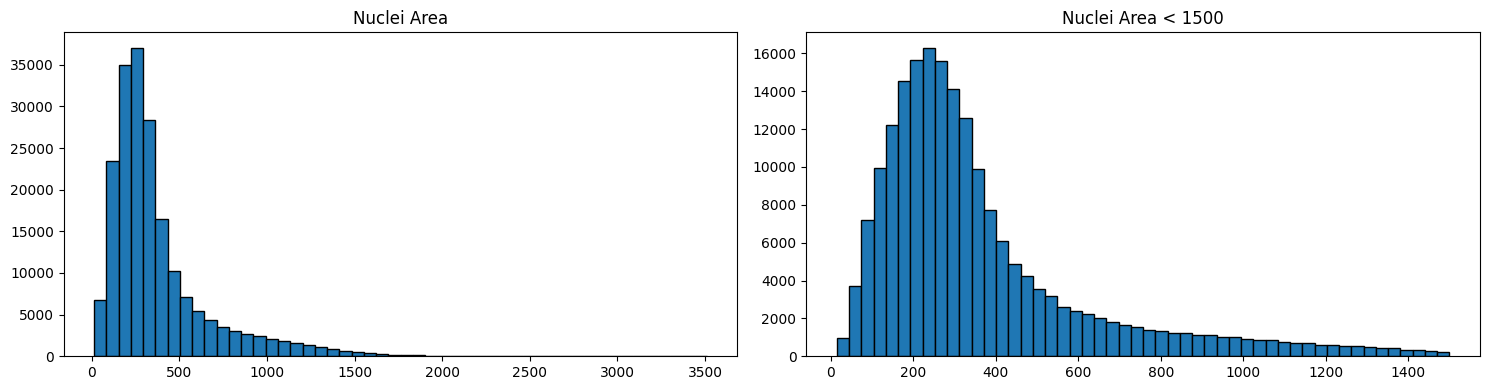

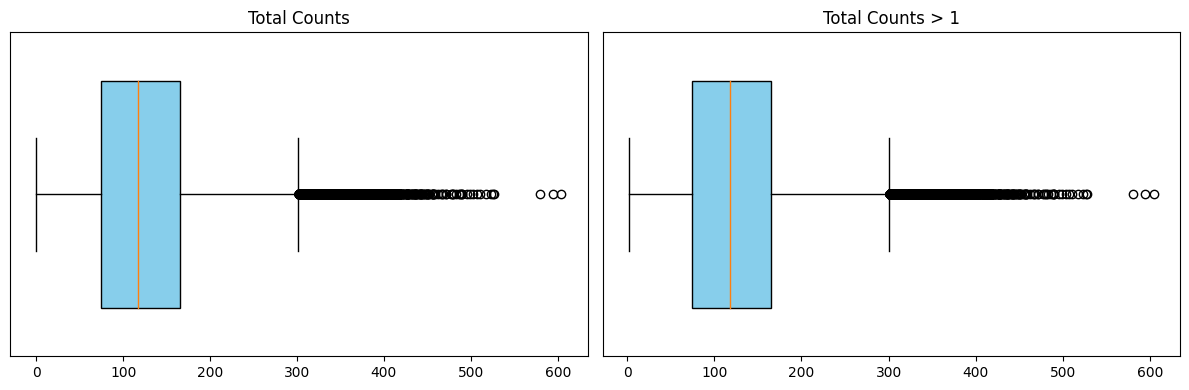

anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered_adata shape: (117348, 18085)


In [102]:
# %%
binning = "exp" # nuc or exp

if binning == "nuc":
    binned_data = grouped_adata 
else:
    binned_data = cell_adata
    binned_data.obs['id']=cell_adata.obs.index

nuc_size_threshold = 1500
# 1a) Calculate each nucleus polygon's area
nuclei_gdf["area"] = nuclei_gdf.geometry.area

# 1b) (Optional) Visualize the distribution of nucleus area
#     Similar to the 10x code's "plot_nuclei_area" function:
def plot_nuclei_area(gdf, area_cut_off):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    # Left: entire distribution
    axs[0].hist(gdf['area'], bins=50, edgecolor='black')
    axs[0].set_title('Nuclei Area')

    # Right: restricted distribution
    axs[1].hist(gdf[gdf['area'] < area_cut_off]['area'], bins=50, edgecolor='black')
    axs[1].set_title('Nuclei Area < ' + str(area_cut_off))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_nuclei_area(nuclei_gdf, area_cut_off=nuc_size_threshold)  # adjust cutoff as needed

# %%
umi_threshold = 1

# 2a) Calculate QC metrics (like total_counts, n_genes_by_counts, etc.)
#     This adds columns in binned_data.obs: "total_counts", "n_genes_by_counts", etc.
sc.pp.calculate_qc_metrics(binned_data, inplace=True)

# 2b) Visualize the distribution of total UMIs
def total_umi(adata_, cut_off):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Left: all data
    axs[0].boxplot(
        adata_.obs["total_counts"],
        vert=False, widths=0.7, patch_artist=True,
        boxprops=dict(facecolor='skyblue')
    )
    axs[0].set_title('Total Counts')

    # Right: only total_counts > cut_off
    axs[1].boxplot(
        adata_.obs["total_counts"][adata_.obs["total_counts"] > cut_off],
        vert=False, widths=0.7, patch_artist=True,
        boxprops=dict(facecolor='skyblue')
    )
    axs[1].set_title('Total Counts > ' + str(cut_off))

    # Remove y-axis ticks
    for ax in axs:
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:
total_umi(binned_data, umi_threshold)  # choose a cutoff

# 3a) Create a mask for nucleus area
#     We'll keep only nucleus IDs (the same 'id' in binned_data.obs)
#     that appear in nuclei_gdf with area < size threshhold.
mask_area = binned_data.obs['id'].isin(
    nuclei_gdf[nuclei_gdf['area'] < nuc_size_threshold]["id"]
)

# 3b) Create a mask for total UMI > 100
mask_count = binned_data.obs["total_counts"] > umi_threshold

# 3c) Combine masks
filtered_adata = binned_data[mask_area & mask_count, :].copy()
print("filtered_adata shape:", filtered_adata.shape)

# 3d) Re-calculate QC metrics for the filtered data, if desired
sc.pp.calculate_qc_metrics(filtered_adata, inplace=True)

In [103]:
# %%


# # 4a) Normalize total counts to 1e4 (or another total) per nucleus
# sc.pp.normalize_total(filtered_adata, target_sum=1e4, inplace=True)

# # 4b) Log-transform the data
# sc.pp.log1p(filtered_adata)

# # 4c) Identify highly variable genes
# #     "Seurat" flavor picks top n genes by variance
# sc.pp.highly_variable_genes(filtered_adata, flavor="seurat", n_top_genes=2000)

# # 4d) PCA on the HVGs
# sc.pp.pca(filtered_adata, use_highly_variable=True)

# # 4e) Build a neighborhood graph
# sc.pp.neighbors(filtered_adata, n_pcs=20)

# # 4f) Leiden clustering
# #     Adjust resolution depending on how many clusters you want
# sc.tl.leiden(filtered_adata, resolution=0.35, key_added="clusters")

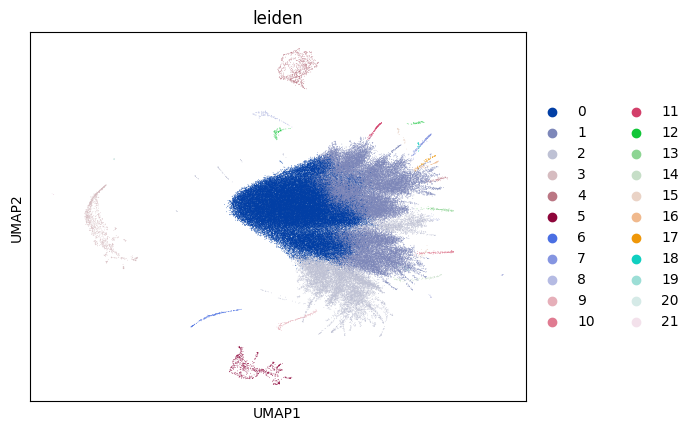

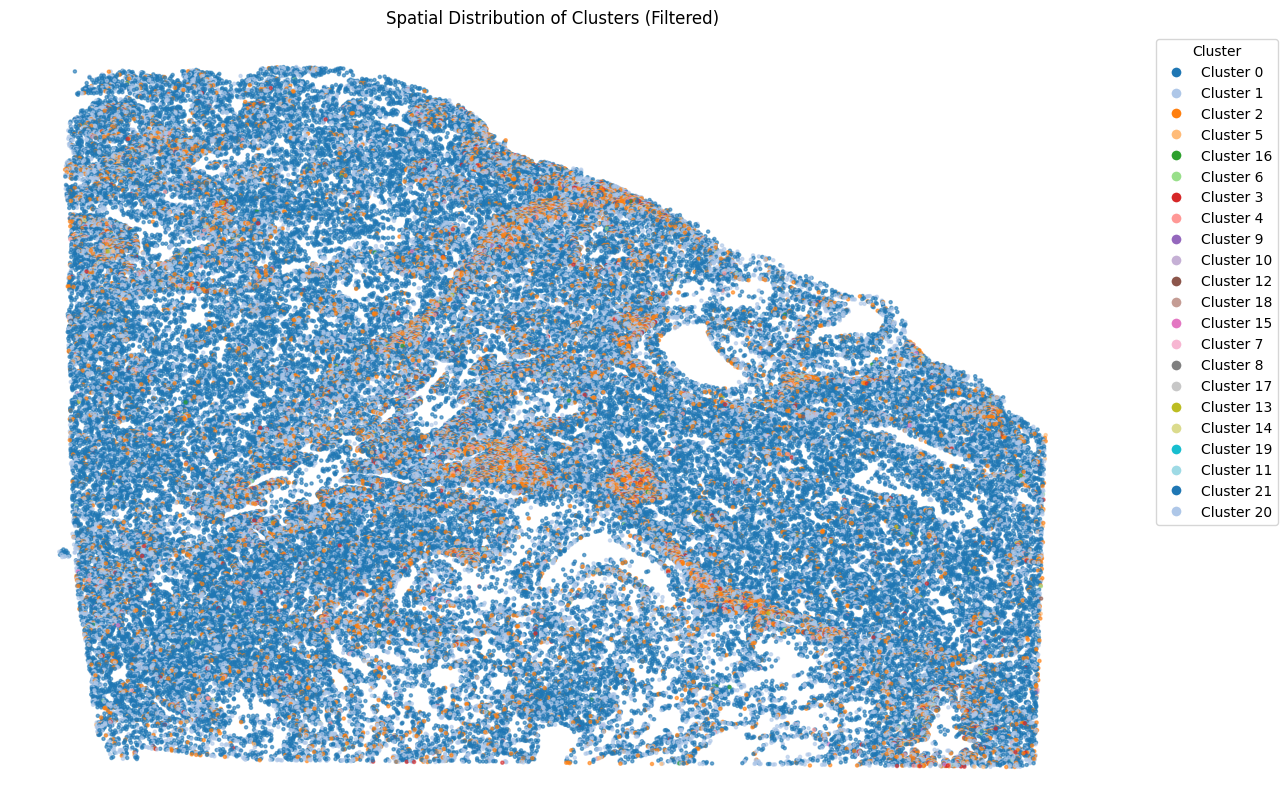

In [104]:
# %%
#  Normalize total counts to 1e4 (or another total) per nucleus
sc.pp.normalize_total(filtered_adata, target_sum=1e4, inplace=True)
# Log-transform the data
sc.pp.log1p(filtered_adata)

# 1a) PCA
sc.pp.pca(filtered_adata, n_comps=50)

# 1b) Build neighbors graph
sc.pp.neighbors(filtered_adata, n_neighbors=10, n_pcs=30)

# 1c) Leiden clustering (resolution can be tweaked)
sc.tl.leiden(filtered_adata, resolution=0.25, key_added="leiden")

# 1d) UMAP (optional, for 2D embedding)
sc.tl.umap(filtered_adata)

# 1e) Now you can do e.g. sc.pl.umap to see the embedding
sc.pl.umap(filtered_adata, color=["leiden"])

# 2a) Ensure you have "x_centroid" and "y_centroid" in filtered_adata.obs
#     If not, you can merge them from your nuclei_gdf or compute them:
#         nuclei_gdf["x_centroid"] = nuclei_gdf.geometry.centroid.x
#         nuclei_gdf["y_centroid"] = nuclei_gdf.geometry.centroid.y
#     Then filtered_adata.obs = filtered_adata.obs.merge(...)

# 2b) Create a color palette for each cluster
unique_clusters = filtered_adata.obs["leiden"].unique().tolist()
cluster_palette = sns.color_palette("tab20", n_colors=len(unique_clusters))

cluster_colors = {
    str(cluster): cluster_palette[i]
    for i, cluster in enumerate(unique_clusters)
}
# Assign colors to each cell according to its cluster
filtered_adata.obs["cluster_color"] = filtered_adata.obs["leiden"].astype(str).map(cluster_colors)

# 2c) Plot the spatial distribution
plt.figure(figsize=(14, 10))

plt.scatter(
    filtered_adata.obs["x_centroid"],
    filtered_adata.obs["y_centroid"],
    c=filtered_adata.obs["cluster_color"].tolist(),
    alpha=0.6,
    s=5
)

plt.xlabel("X Centroid")
plt.ylabel("Y Centroid")
plt.title("Spatial Distribution of Clusters (Filtered)")

# Invert y-axis if your coordinate system has (0,0) top-left
plt.gca().invert_yaxis()

# Construct a legend for the clusters
legend_elements = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        markerfacecolor=color,
        markersize=8,
        label=f"Cluster {cluster}"
    )
    for cluster, color in cluster_colors.items()
]
plt.legend(
    handles=legend_elements,
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.axis("off")
plt.show()

# %%

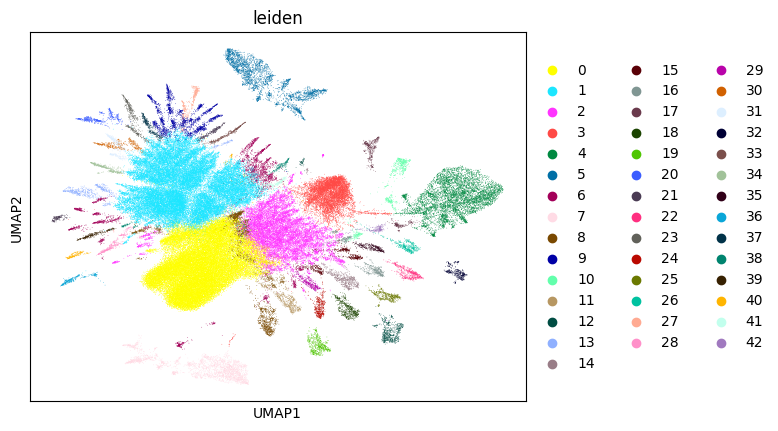

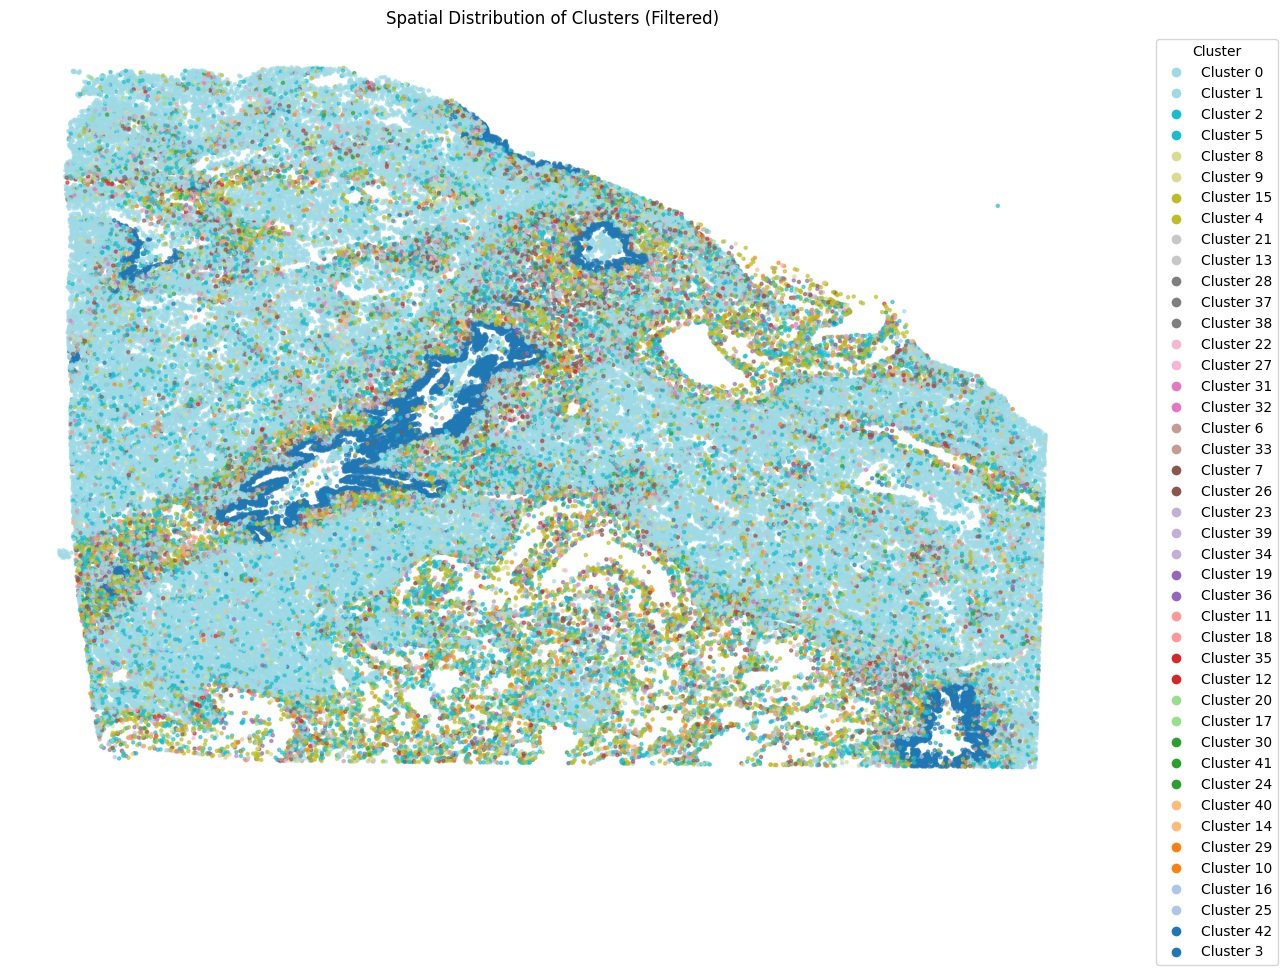

In [105]:
# Compare to bin2cell
b2c_file = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5k_Experiment2/binned_outputs/square_002um/preprocessed/bin2cell/to_tokenize/corrected_cells_matched_preprocessed_refined_v2.h5ad"
b2c_adata = sc.read_h5ad(b2c_file)

#  Normalize total counts to 1e4 (or another total) per nucleus
sc.pp.normalize_total(b2c_adata, target_sum=1e4, inplace=True)
# Log-transform the data
sc.pp.log1p(b2c_adata)

# 1a) PCA
sc.pp.pca(b2c_adata, n_comps=50)

# 1b) Build neighbors graph
sc.pp.neighbors(b2c_adata, n_neighbors=10, n_pcs=30)

# 1c) Leiden clustering (resolution can be tweaked)
sc.tl.leiden(b2c_adata, resolution=0.25, key_added="leiden")

# 1d) UMAP (optional, for 2D embedding)
sc.tl.umap(b2c_adata)

# 1e) Now you can do e.g. sc.pl.umap to see the embedding
sc.pl.umap(b2c_adata, color=["leiden"])

# 2a) Ensure you have "x_centroid" and "y_centroid" in b2c_adata.obs
#     If not, you can merge them from your nuclei_gdf or compute them:
#         nuclei_gdf["x_centroid"] = nuclei_gdf.geometry.centroid.x
#         nuclei_gdf["y_centroid"] = nuclei_gdf.geometry.centroid.y
#     Then b2c_adata.obs = b2c_adata.obs.merge(...)

# 2b) Create a color palette for each cluster
unique_clusters = b2c_adata.obs["leiden"].unique().tolist()
cluster_palette = sns.color_palette("tab20_r", n_colors=len(unique_clusters))

cluster_colors = {
    str(cluster): cluster_palette[i]
    for i, cluster in enumerate(unique_clusters)
}
# Assign colors to each cell according to its cluster
b2c_adata.obs["cluster_color"] = b2c_adata.obs["leiden"].astype(str).map(cluster_colors)

# 2c) Plot the spatial distribution
plt.figure(figsize=(14, 10))

plt.scatter(
    b2c_adata.obs["x_centroid"],
    b2c_adata.obs["y_centroid"],
    c=b2c_adata.obs["cluster_color"].tolist(),
    alpha=0.6,
    s=5
)

plt.xlabel("X Centroid")
plt.ylabel("Y Centroid")
plt.title("Spatial Distribution of Clusters (Filtered)")

# Invert y-axis if your coordinate system has (0,0) top-left
plt.gca().invert_yaxis()

# Construct a legend for the clusters
legend_elements = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        markerfacecolor=color,
        markersize=8,
        label=f"Cluster {cluster}"
    )
    for cluster, color in cluster_colors.items()
]
plt.legend(
    handles=legend_elements,
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.axis("off")
plt.show()